(content:weighted)=
# Weighted Moments

Observed galaxy images are corrupted by noise. Straightforward measures of ellipticity on such images lack robustness, see figure below for example.

Ellipticity  of  the  clean star  image : -0.0040+i0.1980
Ellipticity  of  the  noisy star  image : -0.0050+i0.2190


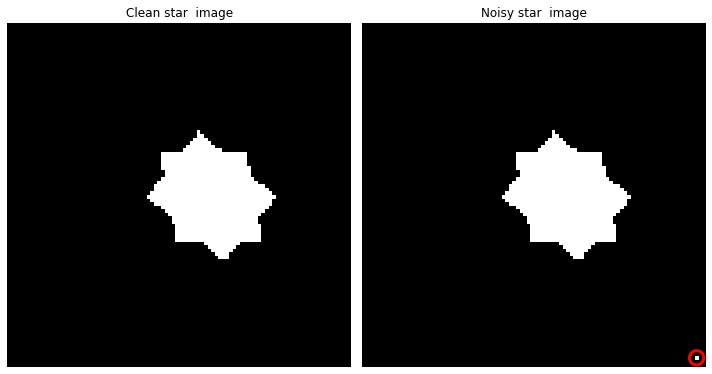

The noisy star and the clean star images are binary images.
They differ from each other by one pixel on the bottom right of the noisy star image.
This pixel induces a difference in ellipticity estimation of : 10.6% between the two images


In [43]:
import numpy as np
import matplotlib.pyplot as plt

def get_centroid(data):
    
    # Sum flux over x and y individually
    sum_i = np.array([np.sum(data, axis=i) for i in (1, 0)])
    
    # Get range of x and y values
    ranges = np.array([np.arange(i) for i in data.shape])
    
    # Calculate centroids
    cents = np.sum(sum_i * ranges, axis=1) / np.sum(data)
    
    return cents.astype(int)

def get_moments(data):
    
    centroid = get_centroid(data)
    ranges = np.array([np.arange(i) for i in data.shape])
    
    x = np.outer(ranges[0] - centroid[0], np.ones(data.shape[1]))
    y = np.outer(np.ones(data.shape[0]), ranges[1] - centroid[1])
    
    q = np.array([np.sum(data * xi * xj) for xi in (x, y) for xj in (x, y)])
    q = (q / np.sum(data)).reshape(2, 2).astype('complex')
    
    return q

def get_ellipticity(data, method='chi'):
    
    # Calculate moments
    q = get_moments(data)
    
    # Calculate the image size.
    r2 = q[0, 0] + q[1, 1]

    # Calculate the numerator
    num = (q[0, 0] - q[1, 1] + 2 * np.complex(0, q[0, 1]))
    
    # Calculate the denominator
    den = r2
    
    if method == 'epsilon':
        den += 2 * np.sqrt(q[0, 0] * q[1, 1] - q[0, 1] ** 2)
    
    # Calculate the ellipticity/polarisation
    ellip = num / den

    return np.around([ellip.real, ellip.imag], 3)

#load toy image and generate noisy image
star_clean = np.load('star.npy')
n_row,n_col = star_clean.shape
star_noisy = np.copy(star_clean)
noise_coord = (n_row-3,n_col-3)
star_noisy[noise_coord] = 1

#estimate ellipticities
e_clean = get_ellipticity(star_clean)
e_noisy = get_ellipticity(star_noisy)
print('Ellipticity  of  the  clean star  image : {:.4f}+i{:.4f}'.format(*e_clean))
print('Ellipticity  of  the  noisy star  image : {:.4f}+i{:.4f}'.format(*e_noisy))

#compute deviation
e_clean_norm = np.linalg.norm(e_clean)
e_noisy_norm = np.linalg.norm(e_noisy)
deviation = np.abs((e_noisy_norm-e_clean_norm)/e_clean_norm)*100

#show image
cmap = 'bone'
plt.figure(3,figsize=(10,7))
plt.subplot(121)
plt.imshow(star_clean,cmap=cmap)
plt.axis('off')
plt.title('Clean star  image')
plt.subplot(122)
plt.imshow(star_noisy,cmap=cmap)
plt.axis('off')
plt.title('Noisy star  image')
circle = plt.Circle(noise_coord, 2, color='r', lw = 3, fill=False)
plt.gcf().gca().add_artist(circle)
plt.tight_layout()
plt.show()
print('The noisy star and the clean star images are binary images.')
print('They differ from each other by one pixel on the bottom right of the noisy star image.')
print('This pixel induces a difference in ellipticity estimation of : {:.1f}% between the two images'.format(deviation))

One way to have more robust measurements is to reduce the weight of the pixels containing only noise in the image before computing the moments. For this purpose we use a weighting window $W$ to define the weighted quadrupole moments of an image as follows:

$$
    Q_{w,k_1 k_2} = \frac{\sum_{x,y} W(x,y) I(x,y) (k_1 - \bar{k_1})(k_2 - \bar{k_2})}{\sum_{x,y} W(x,y) I(x,y)}
$$ (weighted_moments)
with $k_1,k_2 \in \{x,y\}$.
## Weight dependent measures

In equation {eq}`weighted_moments` the output varies with $W$ which means that the resulting shape estimation also varies depending on $W$ see example below. Usually the window is chosen to be the best fit of a 2D Gaussian on the galaxy image. The expression of 2D isotropic Gaussian window centered in 0 is :
$$
W(p) = \frac{1}{2\pi} \exp\left(-\frac{\|p\|^2}{2}\right)
$$
with $p=(x,y)$. Once the centroid, $\bar{p}=\left(\bar{x},\bar{y}\right)$ and the scaling factor $\sigma$ are defined for a specific image, the window is translated and rescaled as :
$$
W\left(\frac{p-\bar{p}}{\sigma}\right) \quad.
$$
```{note}
In the case of isotropic windows, only the norm of the point considered is required and the value of the window can be noted as $W(\|p\|^2)$. 
```

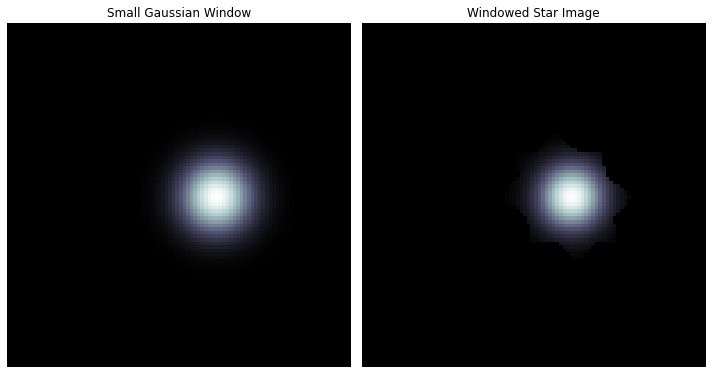

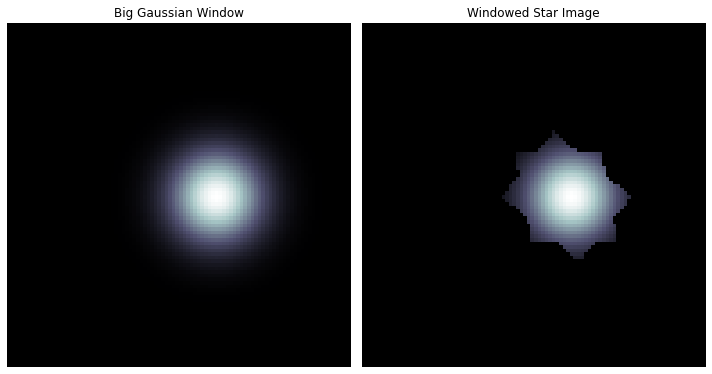

In [44]:
def draw_gaussian(e1, e2, sigma, x_c, y_c, shape):
    
    # compute centered grid
    ranges = np.array([np.arange(i) for i in shape])
    x = np.outer(ranges[0] - x_c, np.ones(shape[1]))
    y = np.outer(np.ones(shape[0]),ranges[1] - y_c)
    
    # shift it to match centroid
    x1 = (1-e1/2)*x - e2/2*y
    y1 = (1+e1/2)*y - e2/2*x
    
    # compute elliptical gaussian
    return np.exp(-(x1 ** 2 + y1 ** 2) / (2 * sigma))

w50 = draw_gaussian(0,0,50,48,58, (96,96))
w80 = draw_gaussian(0,0,80,48,58, (96,96))

plt.figure(4,figsize=(10,7))
plt.subplot(121)
plt.imshow(w50,cmap=cmap)
plt.axis('off')
plt.title('Small Gaussian Window')
plt.subplot(122)
plt.imshow(w40*star_noisy,cmap=cmap)
plt.axis('off')
plt.title('Windowed Star Image')
plt.tight_layout()
plt.show()

plt.figure(5,figsize=(10,7))
plt.subplot(121)
plt.imshow(w80,cmap=cmap)
plt.axis('off')
plt.title('Big Gaussian Window')
plt.subplot(122)
plt.imshow(w80*star_noisy,cmap=cmap)
plt.axis('off')
plt.title('Windowed Star Image')
plt.tight_layout()
plt.show()

In [48]:
#estimate ellipticities
e_w0 = get_ellipticity(w50*star_noisy)
e_w80 = get_ellipticity(w80*star_noisy)
print('Ellipticity  of  the star  image with a small window: {:.4f}+i{:.4f}'.format(*e_w50))
print('Ellipticity  of  the star  image with a large window: {:.4f}+i{:.4f}'.format(*e_w80))

#compute deviation
e_w50_norm = np.linalg.norm(e_w50)
e_w80_norm = np.linalg.norm(e_w80)
deviation_w = np.abs((e_w50_norm-e_w80_norm)/e_w80_norm)*100
print('The choice of the window induces a difference in ellipticity estimation of : {:.1f}% between the two images'.format(deviation_w))

Ellipticity  of  the star  image with a small window: -0.0080+i0.0810
Ellipticity  of  the star  image with a large window: -0.0070+i0.1150
The choice of the window induces a difference in ellipticity estimation of : 29.4% between the two images


The bias induced by the weighting window can be corrected, for more details see [MOMENT BASED METHOD] section.